# Plot the APO model

Plot the modelled $\delta$ APO model, as well as the components

In [1]:
import os, glob
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.convert import concentration

plt.style.use('tableau-colorblind10')

# sys.path.append(os.environ['FUNCS'])
import apo_emiss_func, apo_filter, apo_plot_info, apo_funcs

In [40]:
year = 2014
months = [8, 12] #[mm for mm in range(1, 13)] #
sites = ['WAO'] #'HFD', , 'RGL'
ocean_sims = ['ECCO', 'Jena', 'NEMO']
poster = True

save = False

months = [months] if type(months)==int else months

start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

nrows = len(months) * len(sites)

sites = {site: code for site, code in apo_plot_info.sitecodes.items() if site in sites}

date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[-1]).zfill(2)}' if len(months)==2 else None

print(date_str)

201408-201412


### Get the timeseries data

Import the pre-run forward models

In [41]:
ts_data_all = apo_funcs.get_timeseries(sites=sites.keys(), year=year, sources=['ff', 'ocean', 'bc'])
ts_data_all = {site: {month: ts_site.sel(time=slice(start, end_dates[month]))
                      for month, start in start_dates.items()}
               for site, ts_site in ts_data_all.items()}

species_labels = {source: f'{source.split("_")[0]} FF' if 'ff' in source else
                          f'{source.split("_")[0]} ocean, {[ss for ss in ocean_sims if ss.lower() in source][0]}'
                          if 'ocean' in source else None
                  for source in ts_data_all[list(sites.keys())[0]][months[0]].data_vars}

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2014.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2014.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2014.nc']

Data variables:
['co2_ff', 'o2_ff', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']


### Calculate APO

Calculate the APO contribution from each species

In [4]:
apo_species = {site: {month: apo_emiss_func.apo_species_split(ocean_co2 = ts_month.co2_ocean_nemo,
                                                              ocean_n2 = ts_month.n2_ocean_nemo,
                                                              ocean_o2 = ts_month.o2_ocean_ecco,
                                                              ff_co2 = ts_month.co2_ff,
                                                              ff_o2 = ts_month.o2_ff)
                   for month, ts_month in ts_site.items()}
            for site, ts_site in ts_data_all.items()}

for site, ts_site in ts_data_all.items():
        for month, ts_month in ts_site.items():
                apo_species[site][month] = {'o2_ocean_ecco' if k == 'o2_ocean' else k:v for k,v in apo_species[site][month].items()}
                for sim in ['jena', 'nemo']:
                        apo_species[site][month][f'o2_ocean_{sim}'] = apo_emiss_func.apo_species_split(ocean_o2 = ts_month[f'o2_ocean_{sim}'])['o2_ocean']

### Calculate average contributions

Get the average contribution to APO from the ocean and fossil fuel O2 fluxes

In [5]:
contributions = {site: {month: {sim: np.median(ts_month[f'o2_ocean_{sim}'].values)
                                for sim in ['ecco', 'jena', 'nemo']}
                        for month, ts_month in ts_site.items()}
                for site, ts_site in ts_data_all.items()}
print('Ocean contributions')
print_contribution = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ECCO: {cont_month["ecco"]:.3f};    ' +
                             f'Jena: {cont_month["jena"]:.3f};    NEMO: {cont_month["nemo"]:.3f}')
                       for month, cont_month in cont_site.items()]
                      for site, cont_site in contributions.items()]

contributions_ff = {site: {month: np.mean(ts_month['o2_ff'].values)
                           for month, ts_month in ts_site.items()}
                    for site, ts_site in ts_data_all.items()}
print('O2 ff contributions')
print_contribution = [[print(f'{site}, {apo_plot_info.month_names[month]}: {cont_month:.3f}')
                       for month, cont_month in cont_site.items()]
                      for site, cont_site in contributions_ff.items()]

Ocean contributions
WAO, Jan:    ECCO: -1.896;    Jena: -1.969;    NEMO: -1.338
WAO, Feb:    ECCO: -2.288;    Jena: -1.625;    NEMO: -1.177
WAO, Mar:    ECCO: -0.676;    Jena: -1.154;    NEMO: -0.500
WAO, Apr:    ECCO: 0.512;    Jena: 0.286;    NEMO: 0.448
WAO, May:    ECCO: 2.005;    Jena: 0.105;    NEMO: 3.225
WAO, Jun:    ECCO: 1.841;    Jena: 0.968;    NEMO: 3.869
WAO, Jul:    ECCO: 1.410;    Jena: 1.086;    NEMO: 2.533
WAO, Aug:    ECCO: 0.656;    Jena: 0.341;    NEMO: 1.038
WAO, Sep:    ECCO: 0.285;    Jena: 0.238;    NEMO: 0.353
WAO, Oct:    ECCO: 0.023;    Jena: -0.393;    NEMO: -0.269
WAO, Nov:    ECCO: -0.550;    Jena: -0.886;    NEMO: -0.543
WAO, Dec:    ECCO: -1.248;    Jena: -1.061;    NEMO: -0.998
HFD, Jan:    ECCO: -1.814;    Jena: -2.018;    NEMO: -1.500
HFD, Feb:    ECCO: -2.545;    Jena: -1.709;    NEMO: -1.370
HFD, Mar:    ECCO: -0.595;    Jena: -1.237;    NEMO: -0.444
HFD, Apr:    ECCO: 0.300;    Jena: 0.067;    NEMO: 0.228
HFD, May:    ECCO: 1.923;    Jena: 0.112; 

## Plot the components

First calculate the ocean and ff components and define APO labels

In [5]:
apo_split = {site: {month: {ocean_sim.split("_")[-1]: apo_month['co2_ocean'] + apo_o2 + apo_month['n2_ocean']
                            for ocean_sim, apo_o2 in apo_month.items() if ocean_sim[:8]=='o2_ocean'}
                    for month, apo_month in apo_site.items()}
             for site, apo_site in apo_species.items()}
for site, apo_site in apo_species.items():
    for month, apo_month in apo_site.items():
        apo_split[site][month]['ff'] = apo_month['co2_ff']

apo_labels = {source: 'FF' if source=='ff' else f'ocean, {[ss for ss in ocean_sims if ss.lower()==source][0]}'
              for source in apo_split[list(sites.keys())[0]][months[0]].keys()}

Now plot the components

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_speciesAPO_WAO_201408-201412.png


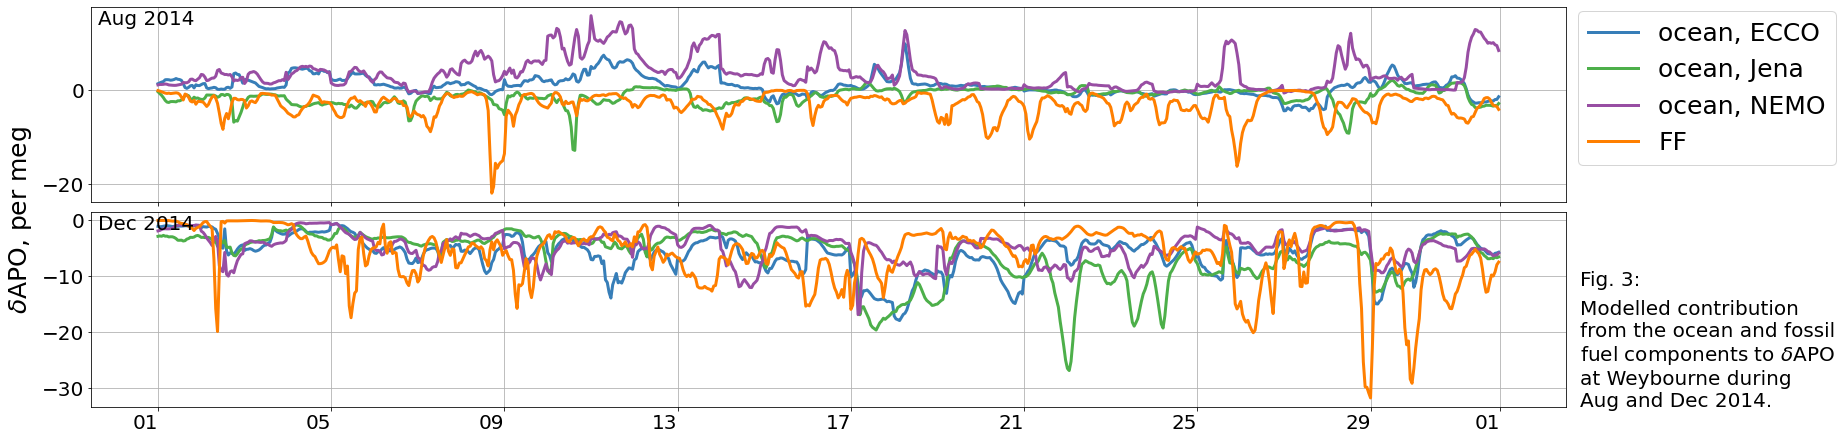

In [105]:
fig, axes = plt.subplots(nrows=len(sites)*len(months), ncols=1, figsize=(25, 3*len(sites)*len(months)), constrained_layout=True)
lines = {site: {month: [apo_month[var.lower()].plot(ax=axes[ss+len(sites)*mm], color=apo_plot_info.colors[var], label=f'{label}', lw=3)
                        for var, label in apo_labels.items()]
                for mm, (month, apo_month) in enumerate(apo_site.items())}
         for ss, (site, apo_site) in enumerate(apo_split.items())}

legend = axes[0].legend(bbox_to_anchor=(1,1.04), fontsize=25)
xlabel = [ax.set_xlabel('') for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
text = {month: axes[len(sites)*mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[len(sites)*mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(months)}
grid = [ax.grid() for ax in axes]

text = axes[-1].text(1.01, 0.7, r'Fig. 3:', transform=axes[-1].transAxes, va='top', fontsize=20)
text = axes[-1].text(1.01, 0.55, r'Modelled contribution' + '\nfrom the ocean and fossil' + '\nfuel components to $\delta$APO' + '\nat Weybourne during' + '\nAug and Dec 2014.', transform=axes[-1].transAxes, va='top', fontsize=20)

if len(sites)>1:
   sites_text = list(sites.values())
   [ax.text(0.01, 0.05, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]
   
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_timeseries_speciesAPO_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_species_WAO_201408.png
Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_species_WAO_201412.png


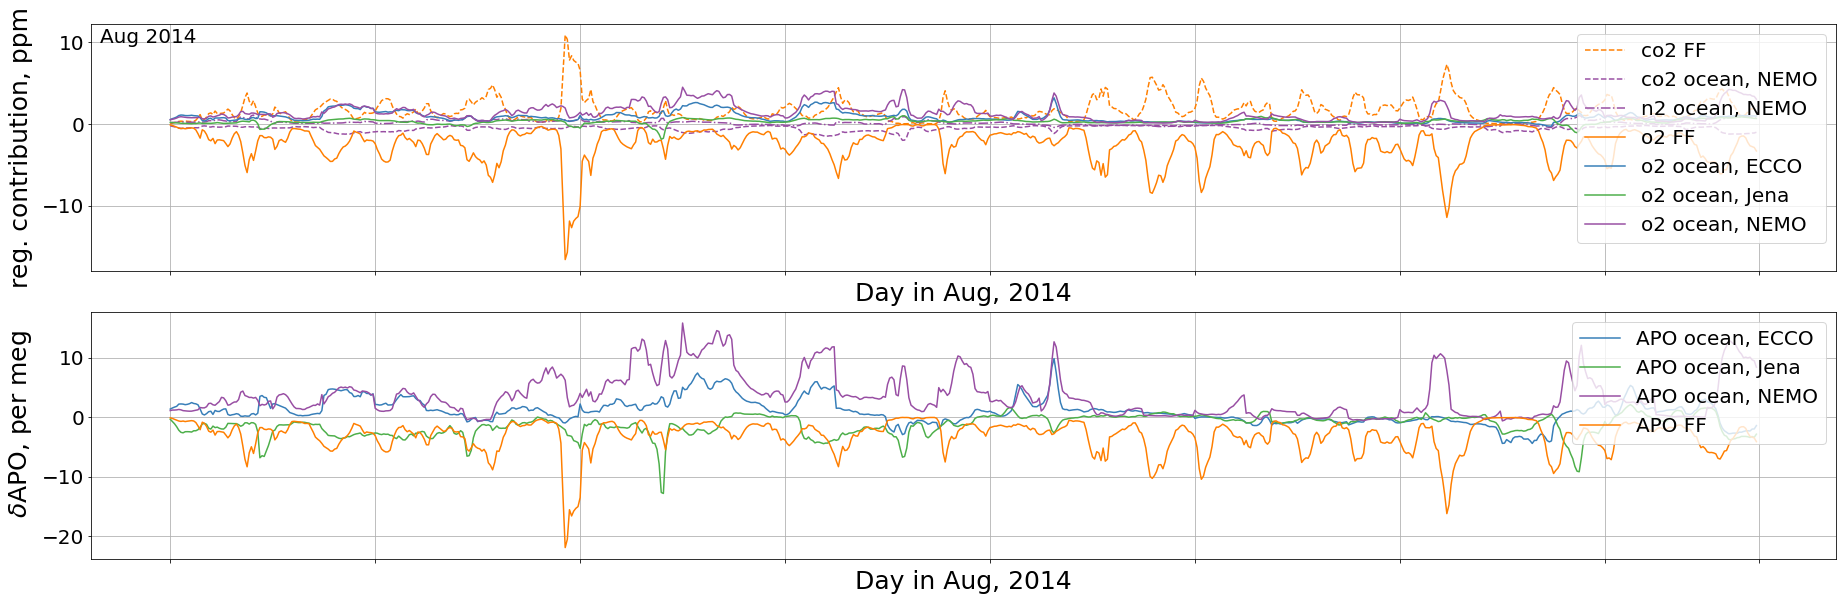

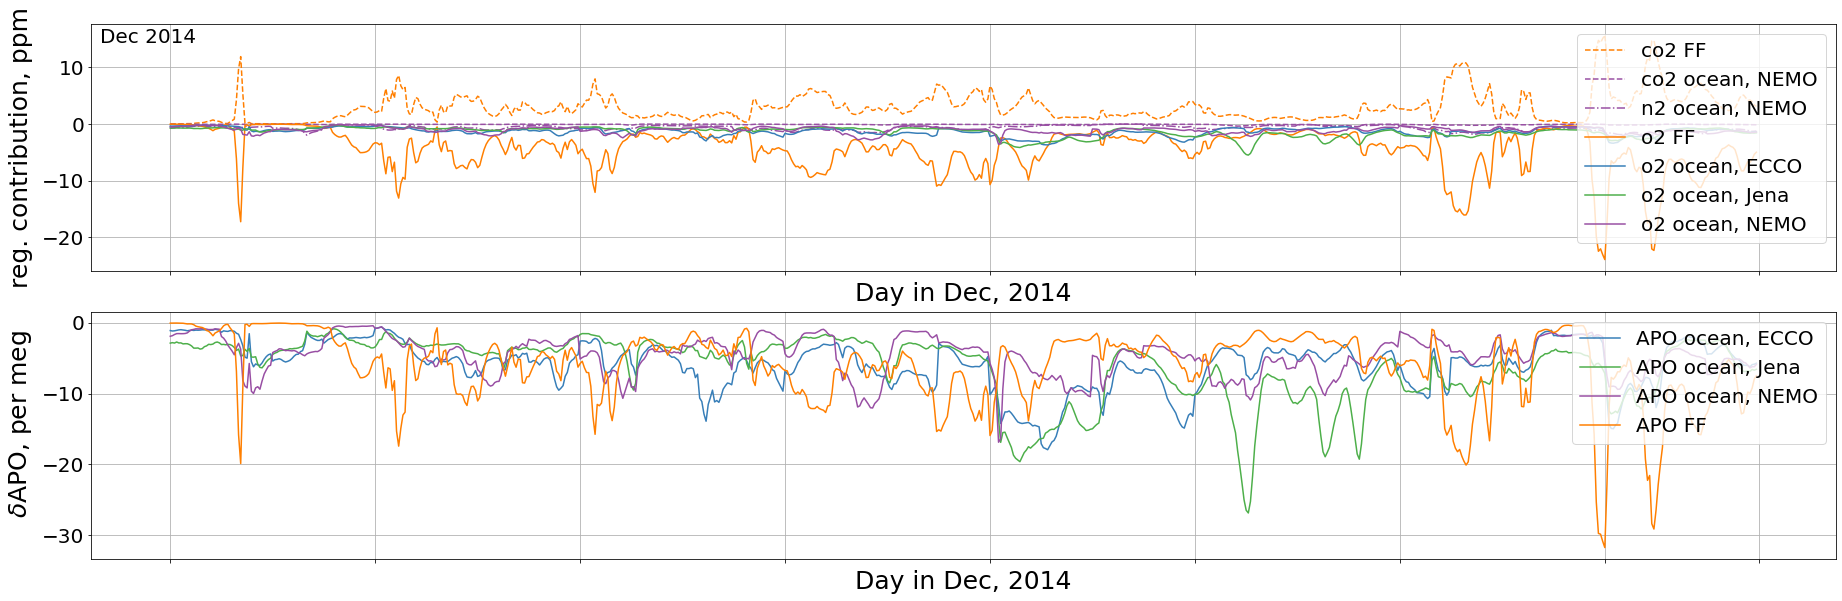

In [6]:
for month in months:
   fig, axes = plt.subplots(nrows=2*len(sites), ncols=1, figsize=(25, 4*2*len(sites)), constrained_layout=True)
   lines = {site: [ts_site[month][var].plot(ax=axes[ss], label=species_labels[var], ls=apo_plot_info.ls[var.split('_')[0]],
                                            color=apo_plot_info.colors_sources[var.split('2_')[1].lower()])
                   for vv, var in enumerate(sorted(ts_site[month].data_vars)) if all([ss not in var for ss in ['diff', 'unc',  'bc']])]
            for ss, (site, ts_site) in enumerate(ts_data_all.items())}

   lines = {site: [apo_site[month][var.lower()].plot(ax=axes[len(sites)+ss], color=apo_plot_info.colors[var], label=f'APO {label}')
                   for var, label in apo_labels.items()]
            for ss, (site, apo_site) in enumerate(apo_split.items())}

   legend = [axes[ii].legend(bbox_to_anchor=(1,1), loc='upper right', fontsize=20) for ii in [i for i in range(len(sites)-1, len(axes))[0%len(sites)::len(sites)]]]
   xlabel = [ax.set_xlabel('') for ax in axes]
   xlabel = [axes[(ii+1)*len(sites)-1].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=25)
             for ii in range(2)]
   ylabel = [ax.set_ylabel('') for ax in axes]
   ylabel = fig.text(-0.01, 0.78, 'reg. contribution, ppm', va='center', ha='center', rotation='vertical', fontsize=25)
   ylabel = fig.text(-0.01, 0.3, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
   # ylabel = axes[0].set_ylabel('regional contribution, ppm', fontsize=22)
   # ylabel = axes[1].set_ylabel('regional contribution, per meg', fontsize=22)
   myFmt = mdates.DateFormatter('%d')
   [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
   ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
   ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii not in [jj*len(sites)+2 for jj in range(2)]]
   text = axes[0].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[0].transAxes, va='top', fontsize=20)
   grid = [ax.grid() for ax in axes]

   if len(sites)>1:
      sites_text = list(sites.values())*2
      [ax.text(0.01, 0.05, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]
   
   filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                           f'APO_timeseries_species_{"-".join(sites)}_{year}{str(month).zfill(2)}.png')
   print(f'Saving to {filename}')
   # fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Calculate the total APO

In [42]:
apo_model = {site: {month: {sim: apo_emiss_func.apo(ocean_co2 = ts_month.co2_ocean_nemo,
                                                    ocean_n2 = ts_month.n2_ocean_nemo,
                                                    ocean_o2 = ts_month[f'o2_ocean_{sim.lower()}'],
                                                    ff_co2 = ts_month.co2_ff,
                                                    ff_o2 = ts_month.o2_ff) + ts_month.apo_bc - apo_plot_info.adjust[year][month]
                            for sim in ocean_sims if sim not in ['ff', 'land', 'obs']}
                    for month, ts_month in ts_site.items()}
             for site, ts_site in ts_data_all.items()}

### Compare the models

- get the differences between the models
- get the correlation betwee models

In [10]:
max_diff = {month: np.max([(apo_month['NEMO'].mean() - apo_month['ECCO'].mean()),  
                           (apo_month['NEMO'].mean() - apo_month['Jena'].mean()),
                           (apo_month['Jena'].mean() - apo_month['ECCO'].mean())])
            for month, apo_month in apo_model['WAO'].items()}

print('--- Maximum average difference between APO models ---')
print_diffs = [print(f'{apo_plot_info.month_names[month]}: {diff_month:.3f}')
               for month, diff_month in max_diff.items()]

--- Maximum average difference between APO models ---
Jan: 3.405
Feb: 5.243
Mar: 3.199
Apr: 5.181
May: 19.117
Jun: 16.826
Jul: 8.575
Aug: 4.865
Sep: 1.395
Oct: 0.080
Nov: 1.397
Dec: 1.593


In [6]:
rmse_models = {site: {month: {'ecco-jena': (((apo_month['ECCO'] - apo_month['Jena'])**2).mean().values)**0.5,
                              'ecco-nemo': (((apo_month['ECCO'] - apo_month['NEMO'])**2).mean().values)**0.5,
                              'jena-nemo': (((apo_month['Jena'] - apo_month['NEMO'])**2).mean().values)**0.5,}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model.items()}

print('--- RMSE between APO models ---')
print_diffs = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ecco-jena: {rmse_month["ecco-jena"]:.3f};    ' +
                      f'ecco-nemo: {rmse_month["ecco-nemo"]:.3f};    nemo-jena: {rmse_month["jena-nemo"]:.3f}')
                for month, rmse_month in rmse_site.items()]
               for site, rmse_site in rmse_models.items()]

--- RMSE between APO models ---
WAO, Jan:    ecco-jena: 5.061;    ecco-nemo: 5.748;    nemo-jena: 4.821
WAO, Feb:    ecco-jena: 6.131;    ecco-nemo: 6.814;    nemo-jena: 4.606
WAO, Mar:    ecco-jena: 5.205;    ecco-nemo: 3.194;    nemo-jena: 4.804
WAO, Apr:    ecco-jena: 5.555;    ecco-nemo: 6.914;    nemo-jena: 10.061
WAO, May:    ecco-jena: 12.019;    ecco-nemo: 17.718;    nemo-jena: 24.841
WAO, Jun:    ecco-jena: 7.882;    ecco-nemo: 16.314;    nemo-jena: 21.686
WAO, Jul:    ecco-jena: 2.840;    ecco-nemo: 11.755;    nemo-jena: 12.564
WAO, Aug:    ecco-jena: 3.681;    ecco-nemo: 4.106;    nemo-jena: 6.649
WAO, Sep:    ecco-jena: 3.274;    ecco-nemo: 2.321;    nemo-jena: 3.805
WAO, Oct:    ecco-jena: 2.620;    ecco-nemo: 3.022;    nemo-jena: 2.224
WAO, Nov:    ecco-jena: 2.740;    ecco-nemo: 1.951;    nemo-jena: 2.953
WAO, Dec:    ecco-jena: 3.701;    ecco-nemo: 3.604;    nemo-jena: 4.192


In [7]:
correlations_models = {site: {month: {'ecco-jena': xr.corr(apo_month['ECCO'], apo_month['Jena']).values**2,
                                      'ecco-nemo': xr.corr(apo_month['ECCO'], apo_month['NEMO']).values**2,
                                      'jena-nemo': xr.corr(apo_month['Jena'], apo_month['NEMO']).values**2,}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model.items()}

print('--- Correlation between APO models ---')
print_diffs = [[print(f'{site}, {apo_plot_info.month_names[month]}:    ecco-jena: {corr_month["ecco-jena"]:.3f};    ' +
                      f'ecco-nemo: {corr_month["ecco-nemo"]:.3f};    nemo-jena: {corr_month["jena-nemo"]:.3f}')
                for month, corr_month in corr_site.items()]
               for site, corr_site in correlations_models.items()]

--- Correlation between APO models ---
WAO, Jan:    ecco-jena: 0.722;    ecco-nemo: 0.767;    nemo-jena: 0.733
WAO, Feb:    ecco-jena: 0.326;    ecco-nemo: 0.533;    nemo-jena: 0.546
WAO, Mar:    ecco-jena: 0.618;    ecco-nemo: 0.866;    nemo-jena: 0.734
WAO, Apr:    ecco-jena: 0.480;    ecco-nemo: 0.746;    nemo-jena: 0.392
WAO, May:    ecco-jena: 0.210;    ecco-nemo: 0.174;    nemo-jena: 0.081
WAO, Jun:    ecco-jena: 0.349;    ecco-nemo: 0.360;    nemo-jena: 0.088
WAO, Jul:    ecco-jena: 0.458;    ecco-nemo: 0.150;    nemo-jena: 0.090
WAO, Aug:    ecco-jena: 0.566;    ecco-nemo: 0.607;    nemo-jena: 0.275
WAO, Sep:    ecco-jena: 0.687;    ecco-nemo: 0.818;    nemo-jena: 0.620
WAO, Oct:    ecco-jena: 0.893;    ecco-nemo: 0.788;    nemo-jena: 0.795
WAO, Nov:    ecco-jena: 0.922;    ecco-nemo: 0.934;    nemo-jena: 0.883
WAO, Dec:    ecco-jena: 0.828;    ecco-nemo: 0.836;    nemo-jena: 0.807


IndexError: index 3 is out of bounds for axis 0 with size 2

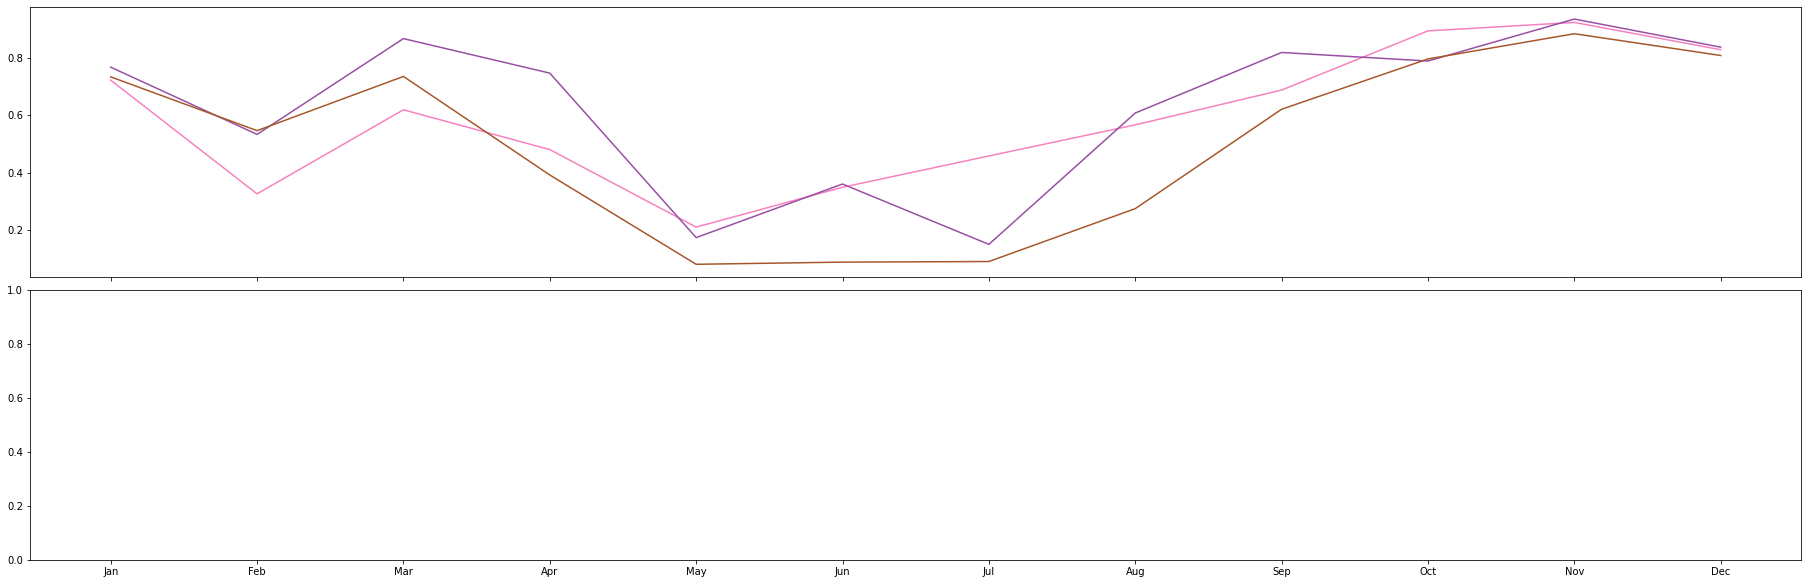

In [14]:
if len(months)>=12:
    sites_plot = ['WAO', 'HFD', 'RGL']

    plot_info_corr = {'unfiltered': {'ls':'-',
                                     'correlation': correlations_models,
                                     'rmse': rmse_models,
                                     'color': {'ecco-jena': '#f781bf', 'ecco-nemo': '#984ea3', 'jena-nemo': '#a65628'}}
    }

    ncols = len([site for site in sites if site in sites_plot])
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 8), sharex=True, sharey='row', constrained_layout=True)

    for info in plot_info_corr.values():
        rmse_plot = [[axes.flatten()[ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in info['correlation'][site].values()],
                                    label=f'{apo_plot_info.model_names[sim.split("-")[0]]}-{apo_plot_info.model_names[sim.split("-")[1]]}',
                                    ls=info['ls'], color=info['color'][sim])
                     for sim in info['correlation'][site][1].keys()] for ss, site in enumerate(sites) if site in sites_plot]

        rmse_plot = [[axes.flatten()[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in info['rmse'][site].values()],
                                                    label=f'{apo_plot_info.model_names[sim.split("-")[0]]}-{apo_plot_info.model_names[sim.split("-")[1]]}',
                                                    ls=info['ls'], color=info['color'][sim])
                    for sim in info['correlation'][site][1].keys()] for ss, site in enumerate(sites) if site in sites_plot]

    ticks = [ax.tick_params(labelsize=20) for ax in axes.flatten()]
    grid = [ax.grid() for ax in axes.flatten()]
    xlabels = [ax.set_xlabel('') for ax in axes.flatten()]
    
    if len(sites_plot)>1:
        legend = axes[0][-1].legend(loc="lower right", fontsize=20)
        ylabels = [axes[ll][0].set_ylabel(label, fontsize=25)
                   for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]
        [axes[0][ss].text(0.01, 0.01, site_text, va='bottom', transform=axes[0][ss].transAxes, fontsize=25) for ss, site_text in enumerate(sites.values())]
    else:
        legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
        ylabels = [axes[ll].set_ylabel(label, fontsize=25)
                   for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_modelcorrelations_{"-".join(sites_plot)}_{date_str}.png')

    if save: 
        print(f'Saving to {filename}')
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Import the observations

In [43]:
apo_obs = {month: get_obs(list(sites.keys()), 'APO', start_date, end_dates[month], keep_missing=True)
           for month, start_date in start_dates.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-08-01 00:00:00 to 2014-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-12-01 00:00:00 to 2014-12-31 23:59:58.999999999


## Plot the model and observations

In [103]:
add_xlabel = False #True #
legend_outside = True
poster = True

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_WAO_201408-201412.png


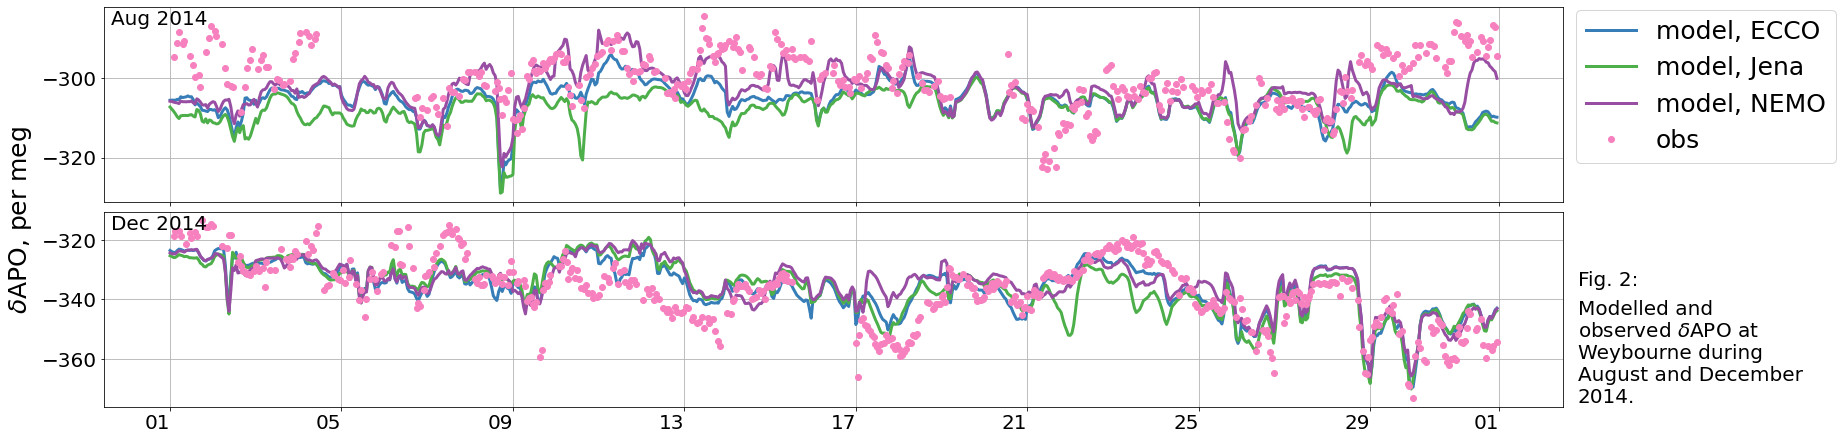

In [64]:
row_size = 3 if len(months) in [4, 6] or poster else 4 if any([len(var)>1 for var in [months, sites]]) else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

model_plots = {site: {month: {sim: apo_sim.plot(ax=axes[ss+mm*len(sites)], color=plot_info.colors[sim.lower()], label=f'model, {sim}', lw=3)
                              for sim, apo_sim in apo_month.items()}
                      for mm, (month, apo_month) in enumerate(apo_site.items())}
               for ss, (site, apo_site) in enumerate(apo_model.items())}
obs_plots = {month: {site: apo_site[0].mf.plot(ax=axes[ss+mm*len(sites)], color='#f781bf', label='obs', marker='o', ls='none', markersize=6)
                           if len(apo_site)>0 else None
                     for ss, (site, apo_site) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
       text = [axes[mm*len(sites)].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

if len(sites)>1:
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites.values())*len(months)
       [ax.text(0.01, 0.05, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

legend = axes[0].legend(fontsize=25, bbox_to_anchor = (1, 1.05)) if legend_outside else \
         axes[0].legend(loc='lower right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
if add_xlabel:
       [axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {plot_info.month_names[month]}', fontsize=25)
       for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\delta$APO, per meg', fontsize=30)

if poster:
       text = axes[-1].text(1.01, 0.7, 'Fig. 2:',
              transform=axes[-1].transAxes, va='top', fontsize=20) 
       text = axes[-1].text(1.01, 0.55, r'Modelled and' + '\nobserved $\delta$APO at' + '\nWeybourne during' + '\nAugust and December' + '\n2014.',
              transform=axes[-1].transAxes, va='top', fontsize=20)

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_timeseries_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Investigate the correlations

Calculate the root mean square error (RMSE) and pearson correlation coefficient

### RMSE: 
This will be smaller for a better fit

$rmse = \sqrt{\sum (P-O)^2 / N}$

$P$ = predicted values (model) \
$O$ = observed values \
$N$ = number of data points

### Pearson correlation coefficient:
This is between 0 and 1, and closer to 1 for a better fit \
(or between 0 and -1 for an anti-correlation)

Xarray has a function to calculate this, using this formula:

$R = \frac{n \sum xy - (\sum x)(\sum y)}{\sqrt{(n \sum x^2 - (\sum x)^2) (n \sum y^2 - (\sum y)^2)}} $

$x, y$ = the two datasets \
$n$ = number of data points

We plot R$^2$


In [44]:
rmse = {site: {month: {model: (((apo_sim.sel(time=slice(start_dates[month], end_dates[month])) - 
                                 apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                       for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model.items()}

correlations = {site: {month: {model: xr.corr(apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                              apo_sim.sel(time=slice(start_dates[month], end_dates[month])))**2
                               for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model.items()}


In [21]:
corr = {}
for key, value in correlations['WAO'].items():
    for k, v in value.items():
        if k not in corr.keys():
            corr[k] = {}
        corr[k][key] = float(v.values)
rmse_ = {}
for key, value in rmse['WAO'].items():
    for k, v in value.items():
        if k not in rmse_.keys():
            rmse_[k] = {}
        rmse_[k][key] = float(v)

In [37]:
corr_seasons = {season: [corr['NEMO'][month] for month in season_months] for season, season_months in plot_info.seasons.items()}
corr_seasons_ave = {season: np.nanmean(np.array(corr_season)) for season, corr_season in corr_seasons.items()}
corr_seasons_ave

{'Spring': 0.04146725318492006,
 'Summer': 0.1821387602770214,
 'Autumn': 0.17938928905522014,
 'Winter': 0.22790622692331006}

In [22]:
print(f'average correlation: {np.nanmean([np.nanmean(list(corr_model.values())) for model, corr_model in corr.items()])}')
print(f'average RMSE: {np.nanmean([np.nanmean(list(rmse_model.values())) for model, rmse_model in rmse_.items()])}')

average correlation: 0.1872754133411579
average RMSE: 10.642730101475044


In [19]:
print('RMSE')
print_rmse = [[print(f'{site}, {plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ECCO"]};   Jena: {rmse_month["Jena"]};   '+
                     f'NEMO: {rmse_month["NEMO"]}; average: {np.array(list(rmse_month.values())).mean()}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {plot_info.month_names[month]} correlation:    ECCO: {corr_month["ECCO"].values};   Jena: {corr_month["Jena"].values};   '+
                     f'NEMO: {corr_month["NEMO"].values}; average: {np.array(list(corr_month.values())).mean()}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations.items()]

RMSE
WAO, Jan rmse:    ECCO: 17.699579925157273;   Jena: 17.71891386477777;   NEMO: 18.90133838460151; average: 18.106610724845517
WAO, Feb rmse:    ECCO: 11.217113041127016;   Jena: 13.662343681732327;   NEMO: 15.982523573530052; average: 13.620660098796465
WAO, Mar rmse:    ECCO: 3.9661250705378692;   Jena: 4.226746102559178;   NEMO: 5.020702737889317; average: 4.404524636995455
WAO, Apr rmse:    ECCO: nan;   Jena: nan;   NEMO: nan; average: nan
WAO, May rmse:    ECCO: nan;   Jena: nan;   NEMO: nan; average: nan
WAO, Jun rmse:    ECCO: 4.039108765700967;   Jena: 3.4523798831406918;   NEMO: 17.480116774755537; average: 8.323868474532398
WAO, Jul rmse:    ECCO: 11.2234939145672;   Jena: 11.303772098469013;   NEMO: 12.87258087672541; average: 11.799948963253874
WAO, Aug rmse:    ECCO: 8.552501830771668;   Jena: 10.84303758162143;   NEMO: 7.4233254460777385; average: 8.93962161949028
WAO, Sep rmse:    ECCO: 13.218528891118423;   Jena: 12.025359076135192;   NEMO: 13.366210227106606; avera

## Apply masks

Filter data for only daytime values

In [20]:
apo_model_day = {site: {month: {sim: apo_filter.filter_time(dataset = apo_sim,
                                                            site = 'WAO',
                                                            hour_start = 11,
                                                            hour_end = 15)
                                for sim, apo_sim in apo_month.items() if len(apo_month)>0}
                        for month, apo_month in apo_site.items()}
                 for site, apo_site in apo_model.items()}
apo_obs_day = {month: {site: apo_filter.filter_time(dataset = apo_site[0].mf,
                                                    site = 'WAO',
                                                    hour_start = 11,
                                                    hour_end = 15)
                       for site, apo_site in apo_month.items() if len(apo_site)>0}
               for month, apo_month in apo_obs.items()}

In [23]:
rmse_day = {site: {month: {model: (((apo_sim.sel(time=slice(start_dates[month], end_dates[month])) - 
                                     apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])))**2).mean().values)**0.5
                       for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model_day.items()}

correlations_day = {site: {month: {model: xr.corr(apo_obs[month][site][0].mf.sel(time=slice(start_dates[month], end_dates[month])),
                                                  apo_sim.sel(time=slice(start_dates[month], end_dates[month])))**2
                               for model, apo_sim in apo_month.items() if len(apo_obs[month][site])>0}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model_day.items()}

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanv

In [24]:
print('RMSE')
print_rmse = [[print(f'{site}, {plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ECCO"]};   ' +
                     f'Jena: {rmse_month["Jena"]};   NEMO: {rmse_month["NEMO"]}; average: {np.array(list(rmse_month.values())).mean()}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse_day.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {plot_info.month_names[month]} correlation:    ECCO: {corr_month["ECCO"].values};   Jena: {corr_month["Jena"].values};   ' +
                     f'NEMO: {corr_month["NEMO"].values}; average: {np.array(list(corr_month.values())).mean()}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations_day.items()]

RMSE
WAO, Jan rmse:    ECCO: 17.13240152290018;   Jena: 16.116435702950966;   NEMO: 18.589118638269483; average: 17.279318621373545
WAO, Feb rmse:    ECCO: 5.844136945592518;   Jena: 10.159502246012252;   NEMO: 12.46713436846392; average: 9.49025785335623
WAO, Mar rmse:    ECCO: 2.649908493980365;   Jena: 2.281989847594203;   NEMO: 5.276363811021888; average: 3.4027540508654854
WAO, Apr rmse:    ECCO: nan;   Jena: nan;   NEMO: nan; average: nan
WAO, May rmse:    ECCO: nan;   Jena: nan;   NEMO: nan; average: nan
WAO, Jun rmse:    ECCO: 4.6067232291727445;   Jena: 4.600960075412259;   NEMO: 19.300384501657827; average: 9.502689268747611
WAO, Jul rmse:    ECCO: 10.731276489205216;   Jena: 10.327614331850938;   NEMO: 12.102458520845868; average: 11.053783113967341
WAO, Aug rmse:    ECCO: 7.789282153985505;   Jena: 10.100749073413578;   NEMO: 6.8356442098573; average: 8.241891812418794
WAO, Sep rmse:    ECCO: 17.201538096400817;   Jena: 15.618464603435283;   NEMO: 17.353044798455812; averag

### Mask high ocean contributions

### Plot correlations

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_correlations_WAO_2014.png


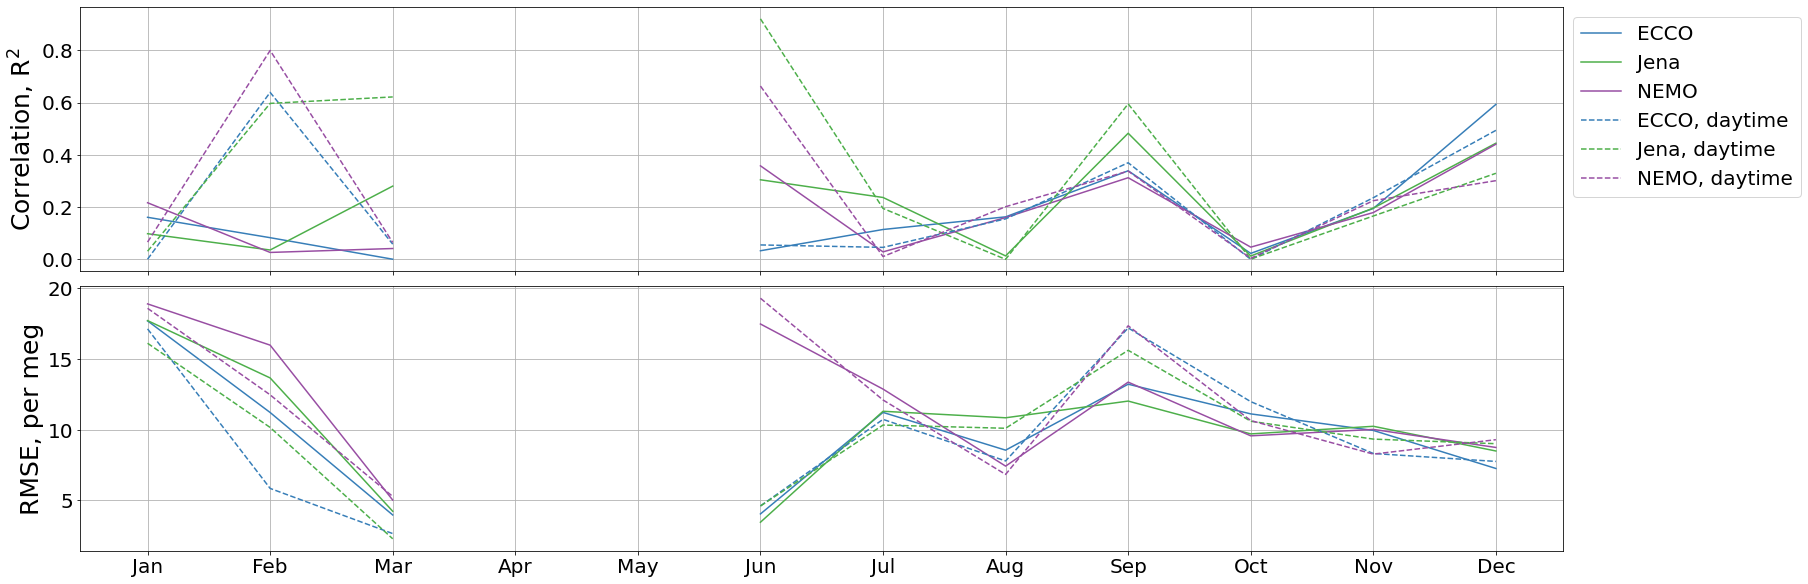

In [35]:
if len(months)>=12:
    sites_plot = ['WAO']

    plot_info_corr = {'unfiltered': {'label': '', 'ls':'-',
                                    'correlation': correlations,
                                    'rmse': rmse},
                    'daytime': {'label': ', daytime', 'ls': '--',
                                'correlation': correlations_day,
                                'rmse': rmse_day}}

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 8*len(sites_plot)), sharex=True, constrained_layout=True)

    for info in plot_info_corr.values():
        rmse_plot = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[apo_plot_info.model_names[sim]] for rr in info['correlation'][site].values()],
                                                    color=apo_plot_info.colors[sim], label=f'{apo_plot_info.model_names[sim]}{info["label"]}', ls=info['ls'])
                    for sim in apo_labels.keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]

    for info in plot_info_corr.values():
        rmse_plot = [[axes[len(sites_plot)+ss].plot(plot_info.month_names.values(), [rr[plot_info.model_names[sim]] for rr in info['rmse'][site].values()],
                                                    color=plot_info.colors[sim], label=f'{plot_info.model_names[sim]}{info["label"]}', ls=info['ls'])
                    for sim in apo_labels.keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]

    ticks = [ax.tick_params(labelsize=20) for ax in axes]
    # legend = axes[0].legend(loc='lower left', fontsize=16)
    legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
            for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Plot the model and observations

In [45]:
add_xlabel = False #True #
legend_outside = True
poster = True

In [46]:
correlations

{'WAO': {8: {'ECCO': <xarray.DataArray ()>
   array(0.1626384),
   'Jena': <xarray.DataArray ()>
   array(0.01315811),
   'NEMO': <xarray.DataArray ()>
   array(0.1598592)},
  12: {'ECCO': <xarray.DataArray ()>
   array(0.59307129),
   'Jena': <xarray.DataArray ()>
   array(0.44447595),
   'NEMO': <xarray.DataArray ()>
   array(0.44064756)}}}

In [49]:
np.nanmean(list(correlations['WAO'][12].values()))

0.49273160065933447

Saving to /user/work/vf20487/Figures/APO_timeseries/APO_timeseries_WAO_201408-201412.png


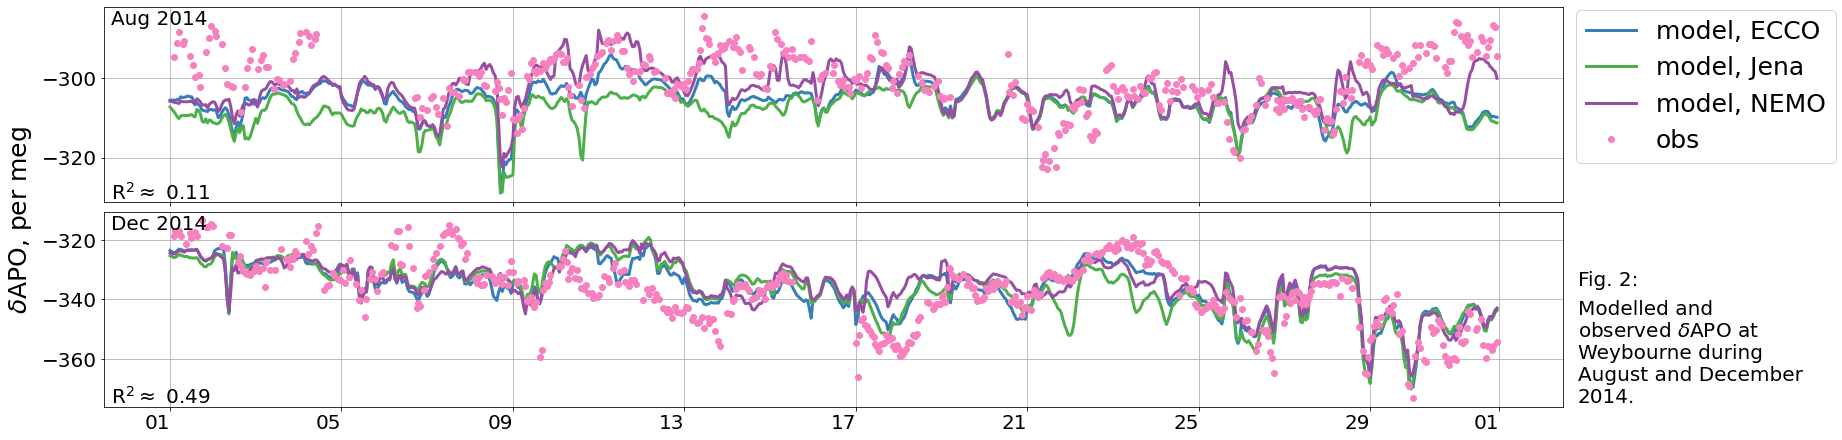

In [67]:
row_size = 3 if len(months) in [4, 6] or poster else 4 if any([len(var)>1 for var in [months, sites]]) else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

model_plots = {site: {month: {sim: apo_sim.plot(ax=axes[ss+mm*len(sites)], color=plot_info.colors[sim.lower()], label=f'model, {sim}', lw=3)
                              for sim, apo_sim in apo_month.items()}
                      for mm, (month, apo_month) in enumerate(apo_site.items())}
               for ss, (site, apo_site) in enumerate(apo_model.items())}
obs_plots = {month: {site: apo_site[0].mf.plot(ax=axes[ss+mm*len(sites)], color='#f781bf', label='obs', marker='o', ls='none', markersize=6)
                           if len(apo_site)>0 else None
                     for ss, (site, apo_site) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

corr_text = {site: {month: axes[ss+mm*len(sites)].text(0.005, 0.015, r'R$^2 \approx$ '+f'{np.round(np.nanmean(list(corr_month.values())), 2)}',
                                                       transform=axes[ss+mm*len(sites)].transAxes, fontsize=20)
                    for mm, (month, corr_month) in enumerate(corr_site.items())}
             for ss, (site, corr_site) in enumerate(correlations.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
       text = [axes[mm*len(sites)].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

if len(sites)>1:
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites.values())*len(months)
       [ax.text(0.01, 0.05, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

legend = axes[0].legend(fontsize=25, bbox_to_anchor = (1, 1.05)) if legend_outside else \
         axes[0].legend(loc='lower right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
if add_xlabel:
       [axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {plot_info.month_names[month]}', fontsize=25)
       for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\delta$APO, per meg', fontsize=30)

if poster:
       text = axes[-1].text(1.01, 0.7, 'Fig. 2:',
              transform=axes[-1].transAxes, va='top', fontsize=20) 
       text = axes[-1].text(1.01, 0.55, r'Modelled and' + '\nobserved $\delta$APO at' + '\nWeybourne during' + '\nAugust and December' + '\n2014.',
              transform=axes[-1].transAxes, va='top', fontsize=20)

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_timeseries_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)